In [1]:

from get_recommendations import get_recommendations,get_convert_type_keys
from matplotlib import pyplot as plt
import matplotlib.ticker
import numpy as np
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import yfinance as yf
from get_stock_data import get_historical_market_data
from get_tickers import get_tickers_filtered,SectorConstants
from analyse_recommendations import get_recommendations_performance
import matplotlib.patches as mpatches
"""
    graph_type:
        'histogram': plot histogram of recommendation performance for a firm (early_stop must be False)
        '1d': plot 1d eventplot graph of recommendation performance (early_stop must be False)
        '2d': plot 2d graph of time vs return recommendation performance (early_stop must be True)

    start:
        look at data past start date 'YYYY-MM-DD'
        
    end:
        look at data up until end date 'YYYY-MM-DD'

    performance_test_period:
        integer
            number of months until recommendation performance is tested
    
    early_stop:
        True: test every recommendation until end of performance_test_period or until new recommendation, whichever comes first

        False: test every recommendation until end of performance_test_period

    data_type
        price: return price

    min_recommendations
        dictionary: min number of recommendations for each recommndation type respectively. Firms without min for any recommendation type will be removed.      Example {Strong Buy:0,Buy:10,Hold:10,Sell:10,Strong Sell:0}
        int: min number of total recommendations for all types. Firms without min recommendations will be removed Example: 10

    convert_type 
        normal:  convert recommendations to {Strong sell, Sell, Hold, Buy, Strong Buy} 
            includes all recommednation types
        simple:  convert recommendations to {Sell, Hold, Buy} 
            groups more confident recommedations together
        reduced: convert recommendations to {Strong sell, Sell, Hold, Buy, Strong Buy} 
            same as normal but doesnt consider 'longer-term buy', 'specultive buy', 'specultive sell'

    verbose
        True: print number of tickers and when each ticker is gathering data
        False: dont print info
    
"""

def graph_performance(graph_type='histogram',tickers=[],start='2012-01-01',end='2020-01-01',performance_test_period=24,data_type='price',early_stop=False,min_recommendations=21,convert_type='simple',verbose=False):
    if early_stop and graph_type !='2d':
        raise ValueError('Can only suppot graph type 2d when early stop is true')
    if graph_type !='1d' and graph_type !='histogram' and graph_type !='2d':
        raise ValueError('Invalid graph_type')
    convert_keys = get_convert_type_keys(convert_type=convert_type)
    if isinstance(min_recommendations, dict):
        if convert_type == 'normal' and len(min_recommendations) != 5:
            raise ValueError('Normal recommendation convertion has 5 types need min recommendation dictionary to have 5 integer values')
        if convert_type == 'reduced' and len(min_recommendations) != 5:
            raise ValueError('Reduced recommendation convertion has 5 types need min recommendation dictionary to have 5 integer values')
        if convert_type == 'simple' and len(min_recommendations) != 3:
            raise ValueError('Simple recommendation convertion has 3 types need min recommendation dictionary to have 3 integer values')
        if set(min_recommendations.keys()) != set(convert_keys):
            raise ValueError('Invalid value for some min_recommendation key')
    if (not isinstance(performance_test_period,int)) or performance_test_period <= 0:
        raise ValueError('Invalid performance_test_period')

    df_firm_perf,df_time_total = get_recommendations_performance(tickers=tickers,start=start,end=end,performance_test_period=performance_test_period,early_stop=early_stop,data_type=data_type,convert_type=convert_type,verbose=verbose)

    df_new_firm_perf = df_firm_perf.copy()
    if graph_type == 'histogram':
        plt.style.use('seaborn-deep')
    for firm_name,firm_perf in df_firm_perf.iterrows():
        
        #count number of recommendations
        found = False
        if isinstance(min_recommendations, dict):
            for rec in min_recommendations:
                if not isinstance(firm_perf[rec],np.ndarray):
                    if min_recommendations[rec] > 0:
                        df_new_firm_perf.drop([firm_name],inplace=True)
                        found = True
                        break
                elif len(firm_perf[rec]) < min_recommendations[rec]:
                    df_new_firm_perf.drop([firm_name],inplace=True)
                    found = True
                    break
        if isinstance(min_recommendations, int):
            total_recommendations = 0
            for rec in convert_keys:
                if isinstance(firm_perf[rec],np.ndarray):
                    total_recommendations = total_recommendations + len(firm_perf[rec])
            if total_recommendations < min_recommendations:
                df_new_firm_perf.drop([firm_name],inplace=True)
                found = True

        if found:
            continue
        
        if graph_type=='2d':
            plt.title(firm_name)
            colors = {}   
            if len(convert_keys) == 5:
                colors = {'Strong Sell':'darkred','Sell':'red','Hold':'gold','Buy':'lightgreen','Strong Buy':'green'}
            if len(convert_keys) == 3:
                colors = {'Sell':'red','Hold':'gold','Buy':'green'}
            inc = 0
            patches = []
            
            for rec in convert_keys:

                if isinstance(firm_perf[rec],np.ndarray):

                    price_sum_log_values = np.array([0.0])
                    time_sum_values = np.array([0.0])

                    #array of performances based on recommendation
                    perf_array = firm_perf[rec]
                    time_array = df_time_total.at[firm_name,rec]

                    
                    #get total time in seconds 
                    time_of_investments = np.sum(df_time_total.at[firm_name,rec])

                    for perf,time in zip(perf_array,time_array):
                        price_sum_log_values = np.append(price_sum_log_values,price_sum_log_values[-1]+np.log(perf+1))
                        time_sum_values = np.append(time_sum_values,time_sum_values[-1]+time/time_of_investments)

                    
                    
                    seconds_in_year = 31622400.0
                    price_geo_avg_log_values = price_sum_log_values*seconds_in_year/time_of_investments
                    price_geo_avg_values = np.exp(price_geo_avg_log_values)

                    #price_geo_avg_values = price_geo_avg_values-1.0

                    #plot data
                    patch = mpatches.Patch(color=colors[rec], label=rec)
                    patches.append(patch)
                    
                    plt.plot(time_sum_values,price_geo_avg_values,color=colors[rec])  # Draw a horizontal line
                    
                        
                    inc = inc + 1
            plt.yscale('log')
            plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
            plt.legend(handles=patches)  
            plt.show()

        
        
        elif graph_type == '1d':
            plt.figure()
            plt.title(firm_name)
            colors = {}   
            if len(convert_keys) == 5:
                colors = {'Strong Sell':'darkred','Sell':'red','Hold':'gold','Buy':'lightgreen','Strong Buy':'green'}
            if len(convert_keys) == 3:
                colors = {'Sell':'red','Hold':'gold','Buy':'green'}
            inc = 0
            patches = []
            
            for rec in convert_keys:
                if isinstance(firm_perf[rec],np.ndarray):

                    #array of performances based on recommendation
                    perf_array = firm_perf[rec]

                    #calculate average rate of return needs 
                    arr = np.array([])
                    #get yearly rate of return 
                    for perf in perf_array:
                        ret = np.power(perf+1.0,12.0/performance_test_period)-1.0
                        arr = np.append(arr,ret)

                    patch = mpatches.Patch(color=colors[rec], label=rec)
                    patches.append(patch)
                    
                    plt.vlines(arr,0,5-inc,colors=colors[rec])  # Draw a horizontal line
                        
                    inc = inc + 1
                
            plt.legend(handles=patches)  
            plt.xlim(-1, 2)
            frame1 = plt.gca()
            frame1.axes.get_yaxis().set_visible(False)
            plt.show()

        elif graph_type == 'histogram':
            color_dict = {}  
            plots = None
            fig = None
            if len(convert_keys) == 5:
                color_dict = {'Strong Sell':'#8b0000','Sell':'#ff0000','Hold':'#daa520','Buy':'#90ee2c','Strong Buy':'#00ff00'}
                fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,7))
                plots = (ax1, ax2, ax3, ax4, ax5)
            elif len(convert_keys) == 3:
                color_dict = {'Sell':'#ff0000','Hold':'#daa520','Buy':'#00ff00'}
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3 , figsize=(25,7))
                plots = (ax1, ax2, ax3)
            inc = 0
            patches = []
            rec_values = []
            weights = []
            
            
            fig.suptitle(firm_name)
            inc = 0
            for rec in convert_keys:
                if isinstance(firm_perf[rec],np.ndarray):

                    #array of performances based on recommendation
                    perf_array = firm_perf[rec]
                    
                    patch = mpatches.Patch(color=color_dict[rec], label=rec)
                    patches.append(patch)

                    #calculate average rate of return needs 
                    x = np.array([])
                    #get yearly rate of return 
                    for perf in perf_array:
                        ret = np.power(perf+1.0,12.0/performance_test_period)-1.0
                        x = np.append(x,ret)
                    #get weight 
                    x_w = np.empty(x.shape)
                    x_w.fill(1/x.shape[0])
                    #get mean
                    me = np.mean(x)

                    #set sub plot title
                    plots[inc].set(xlabel=rec+" Avg: "+ str(me))

                    #graph histogram
                    plots[inc].hist(x, 60, weights=x_w, color=color_dict[rec])
                    inc = inc + 1

            #plt.legend(handles=patches)  
            plt.show()
                


- BEKE: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- CPNG: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- DASH: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- LU: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- PLTR: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- RBLX: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- RKT: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- SNOW: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- STLA: No data found for this date range, symbol may be delisted
- ABNB: Data doesn't exist for startDate = 1325394000, endDate = 1577854800


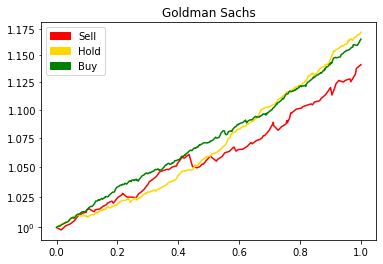

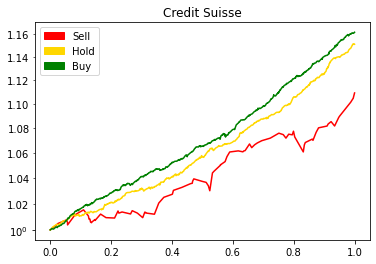

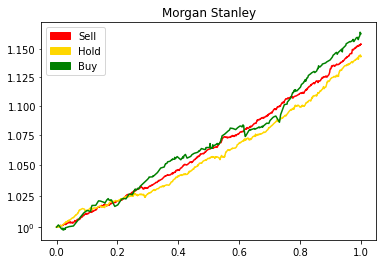

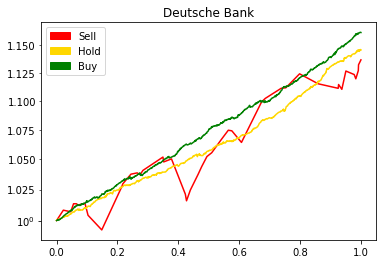

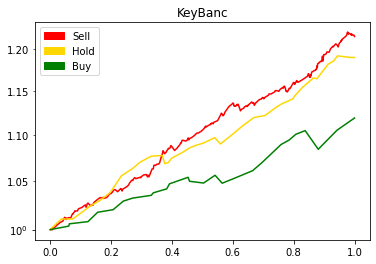

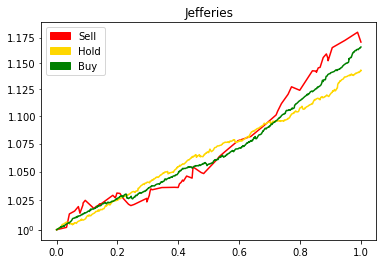

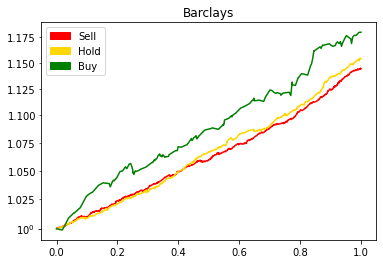

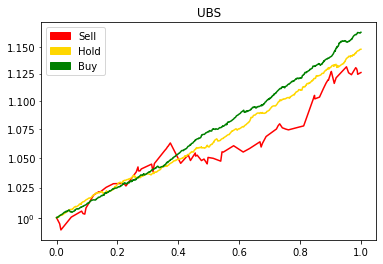

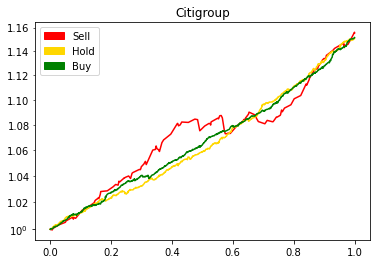

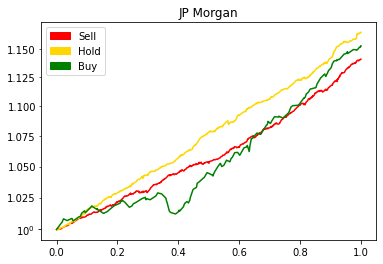

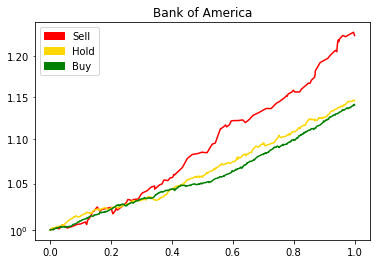

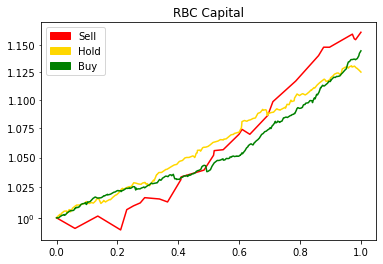

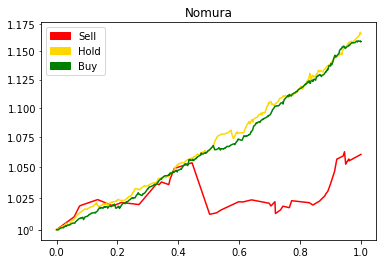

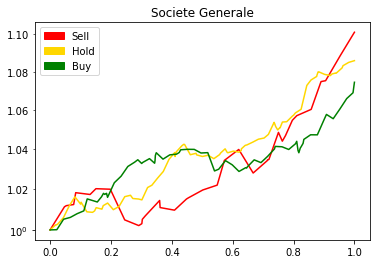

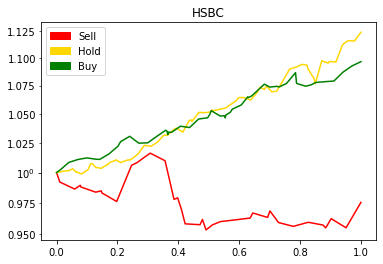

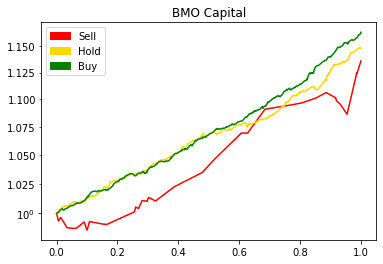

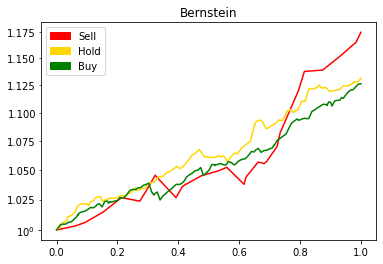

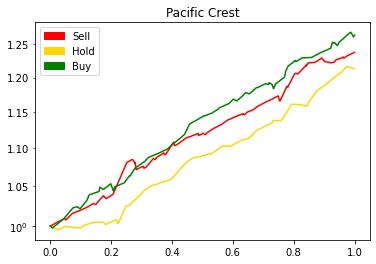

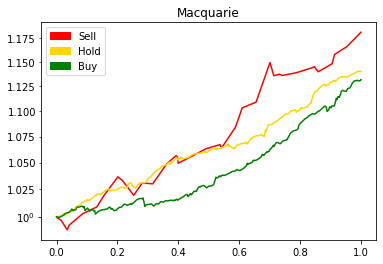

In [2]:
#graph analyst recommendation performance on 2d graph, normalized to 1 year. Early stop is true
graph_performance(graph_type='2d',tickers=get_tickers_filtered(mktcap_min=30e3),start='2012-01-01',end='2020-01-01',performance_test_period=24,data_type='price',early_stop=True,min_recommendations={'Sell': 25,'Hold': 25,'Buy': 25},convert_type='simple',verbose=False)


- BEKE: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- CPNG: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- DASH: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- LU: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- PLTR: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- RBLX: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- RKT: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- SNOW: Data doesn't exist for startDate = 1325394000, endDate = 1577854800
- STLA: No data found for this date range, symbol may be delisted
- ABNB: Data doesn't exist for startDate = 1325394000, endDate = 1577854800


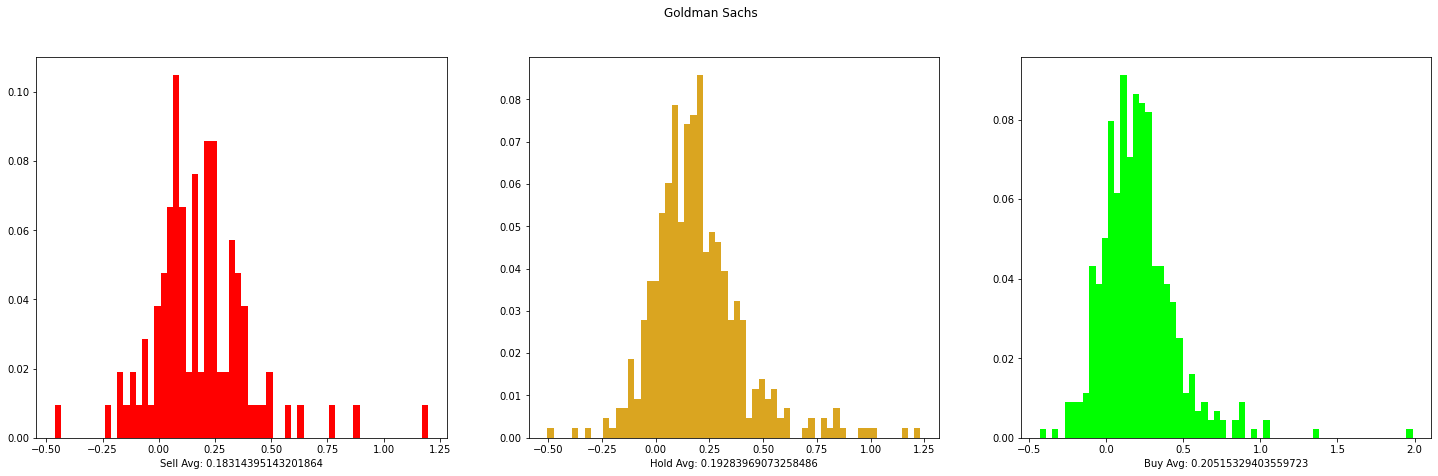

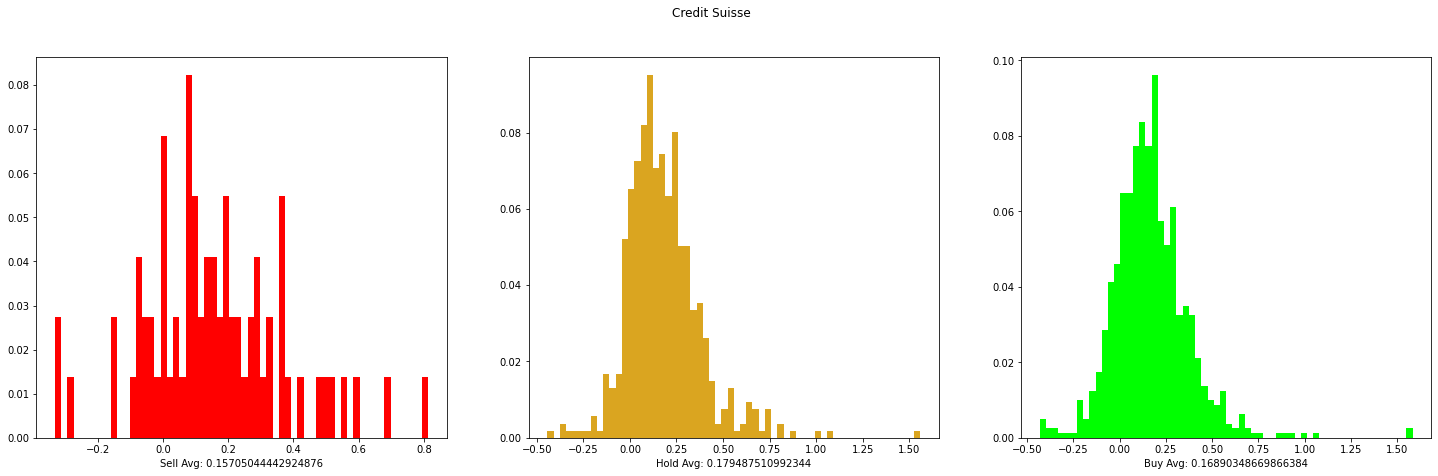

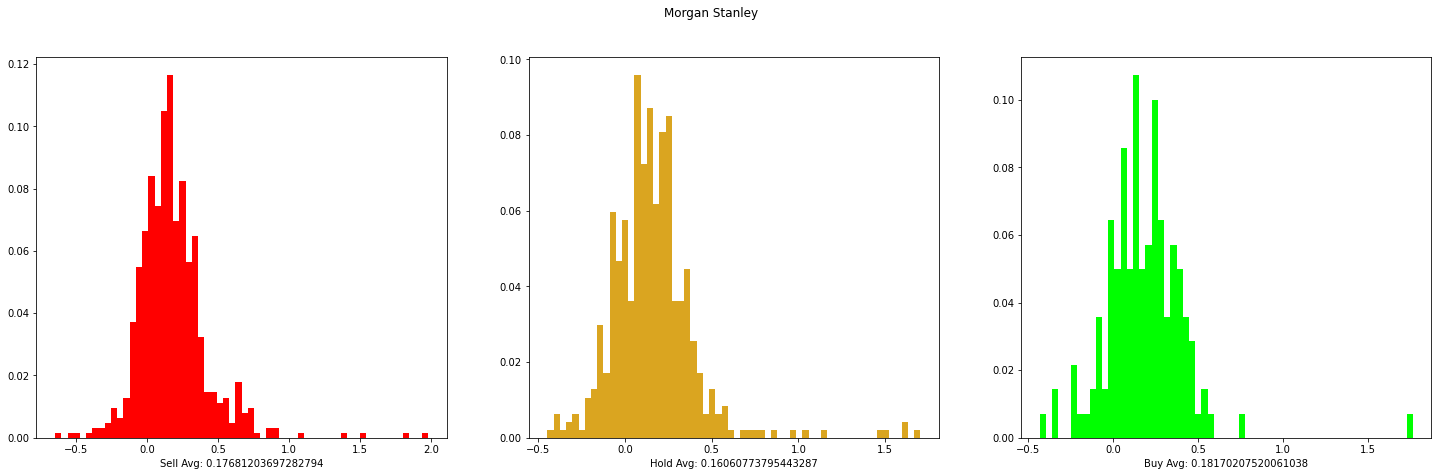

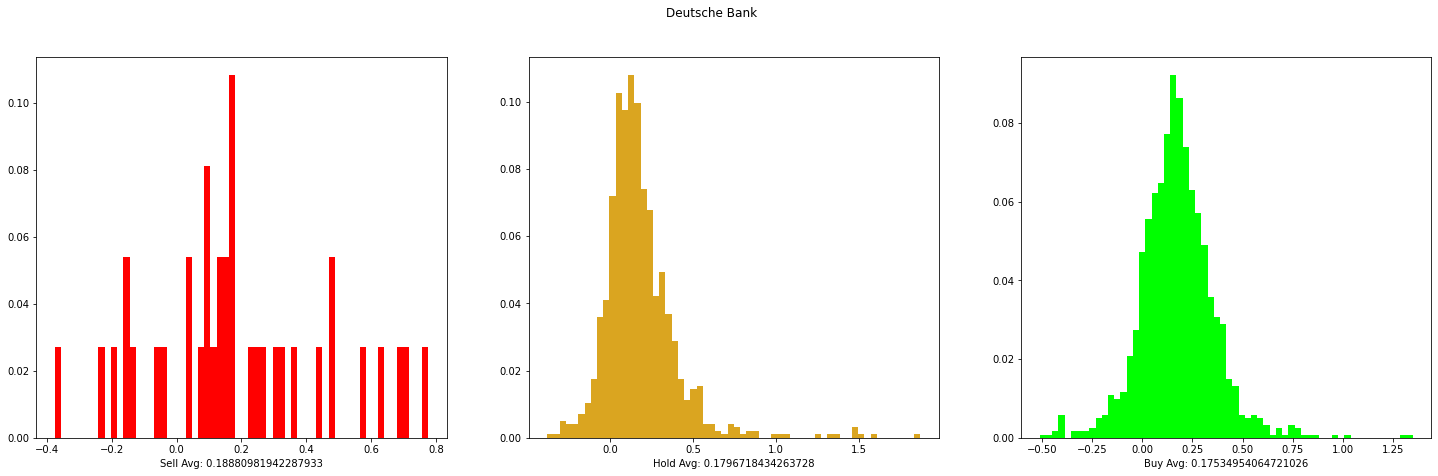

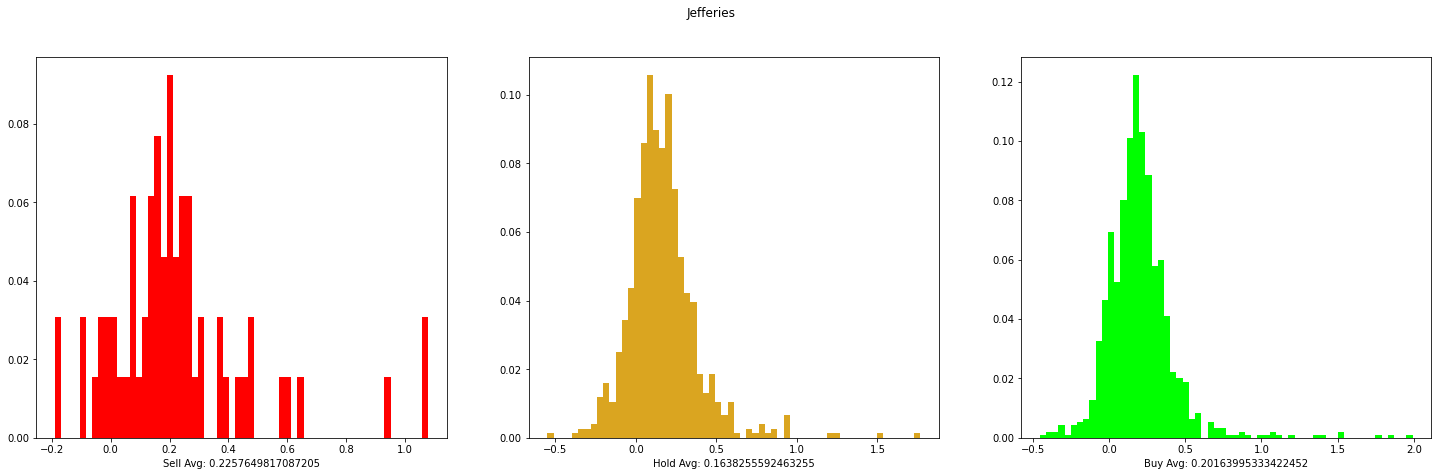

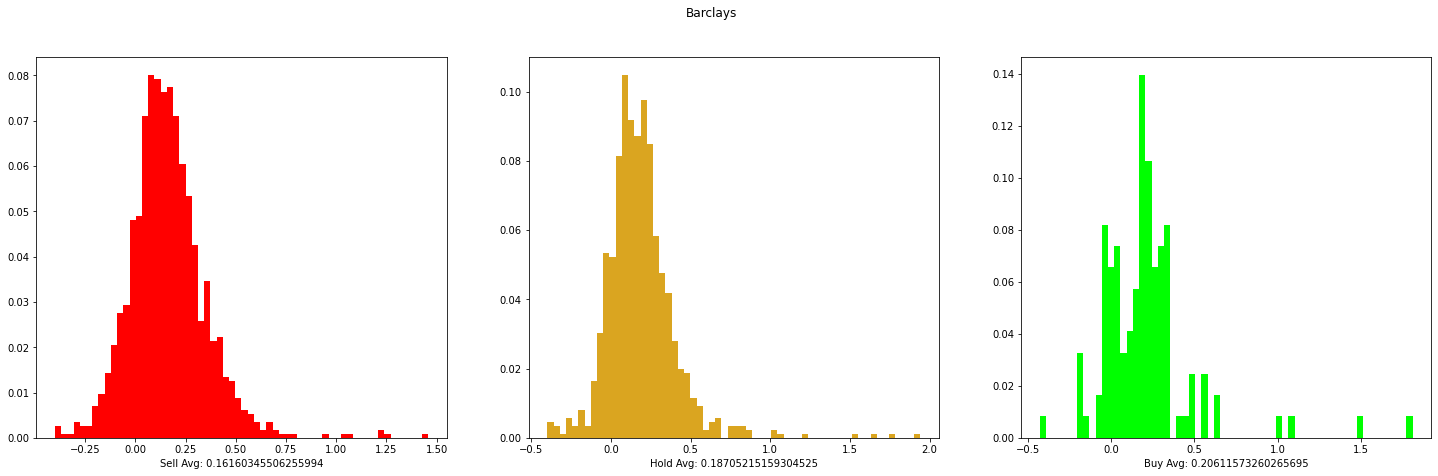

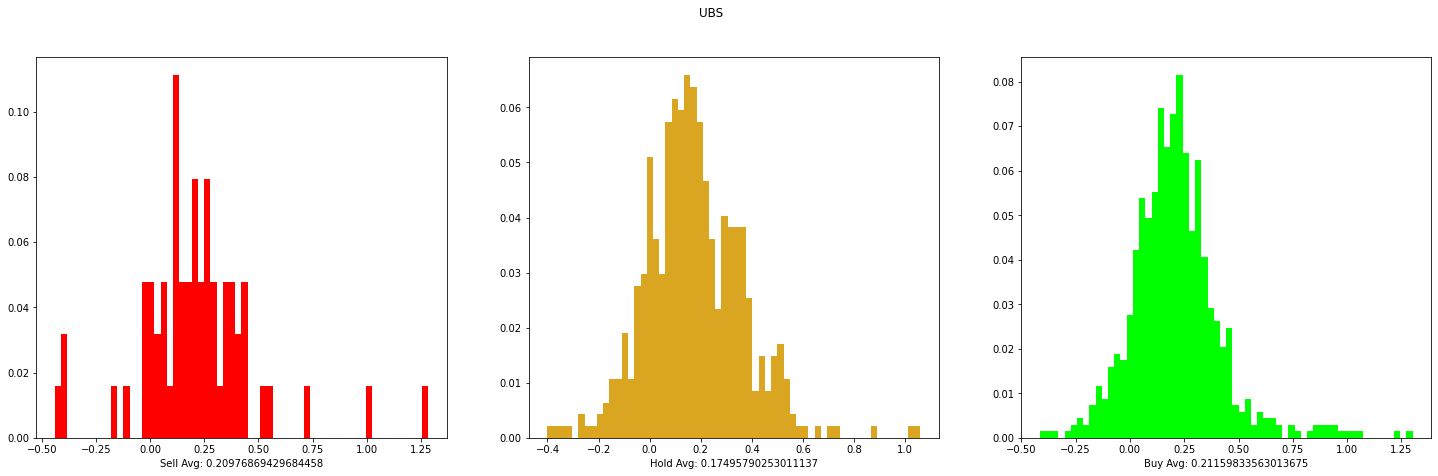

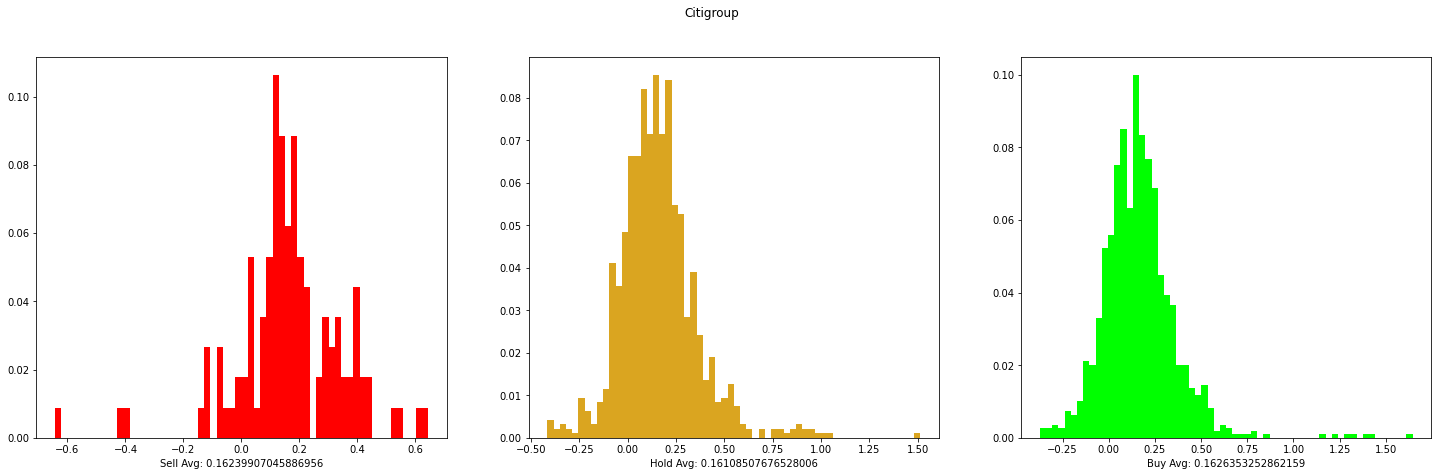

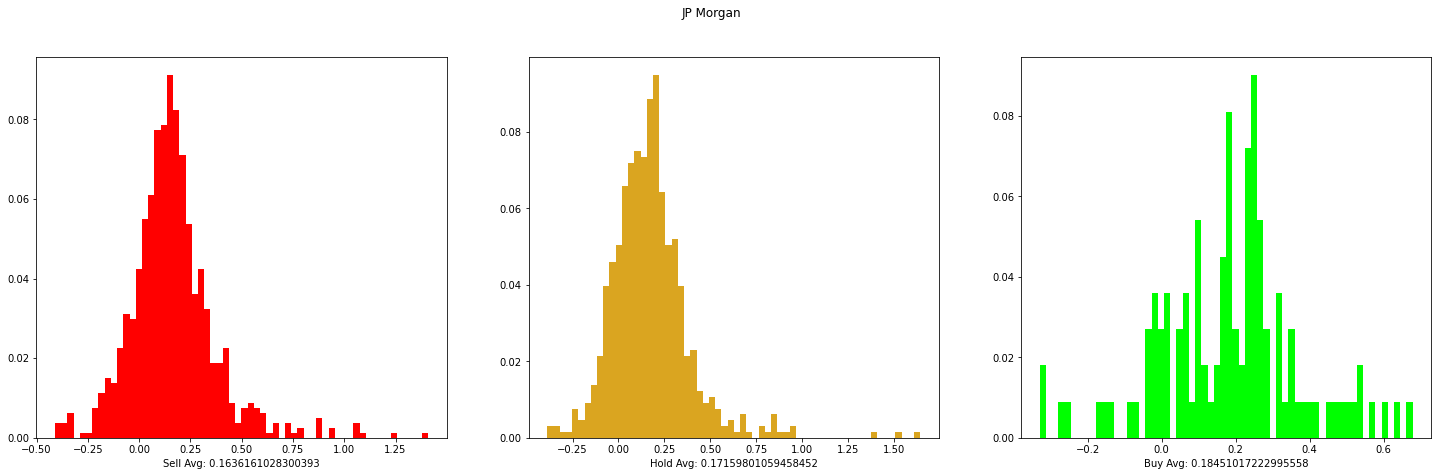

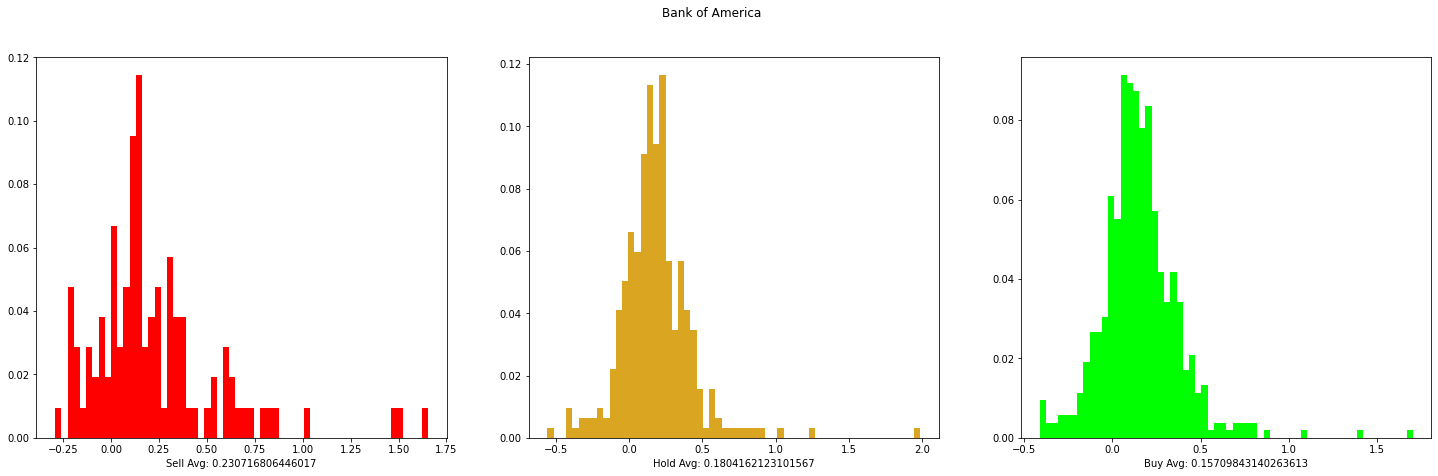

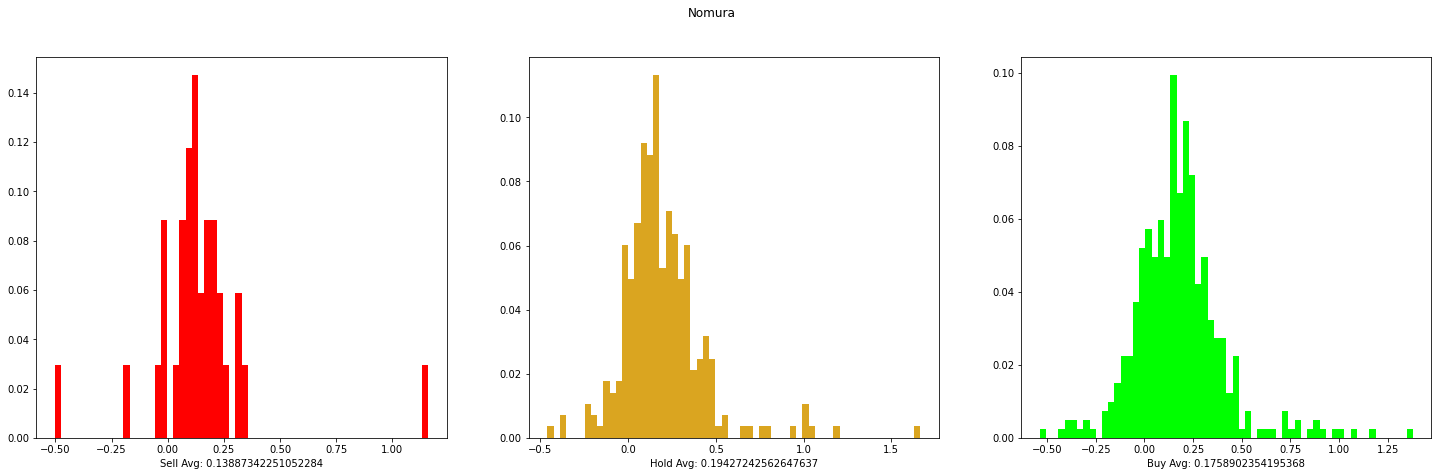

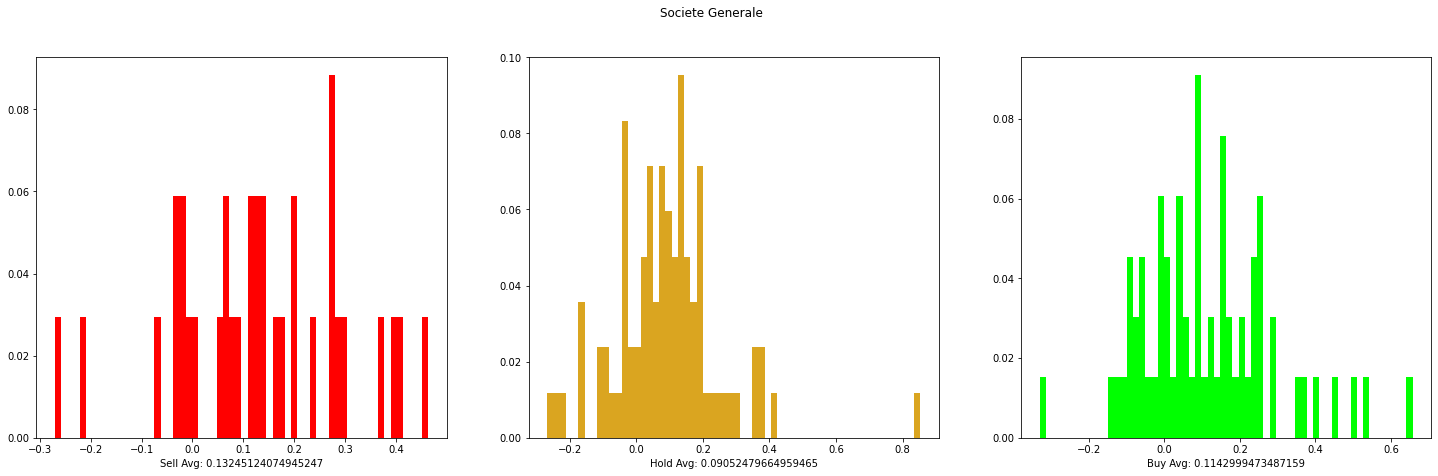

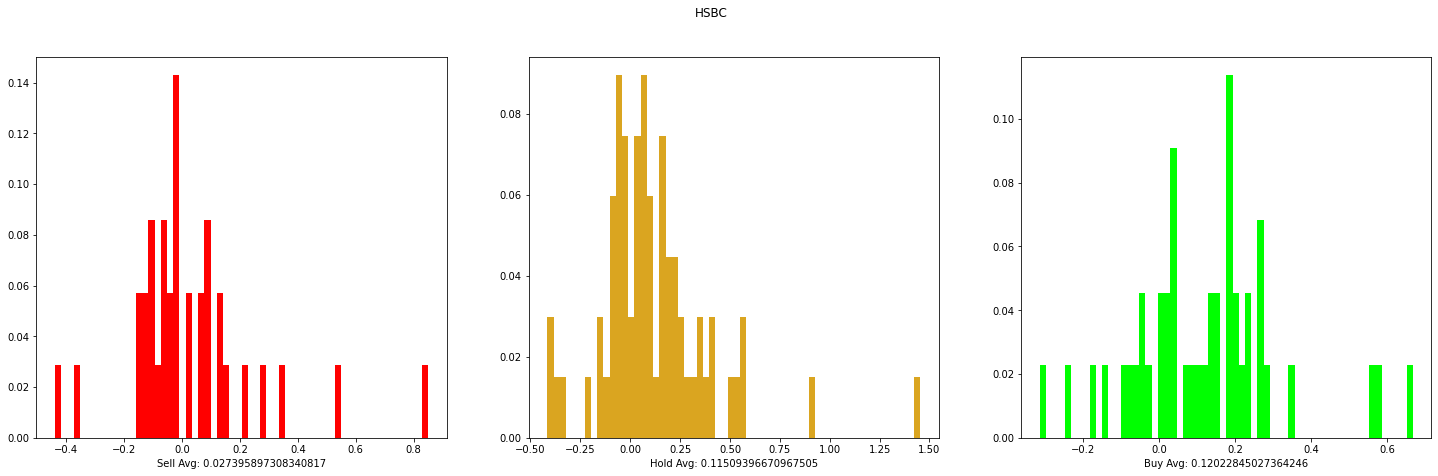

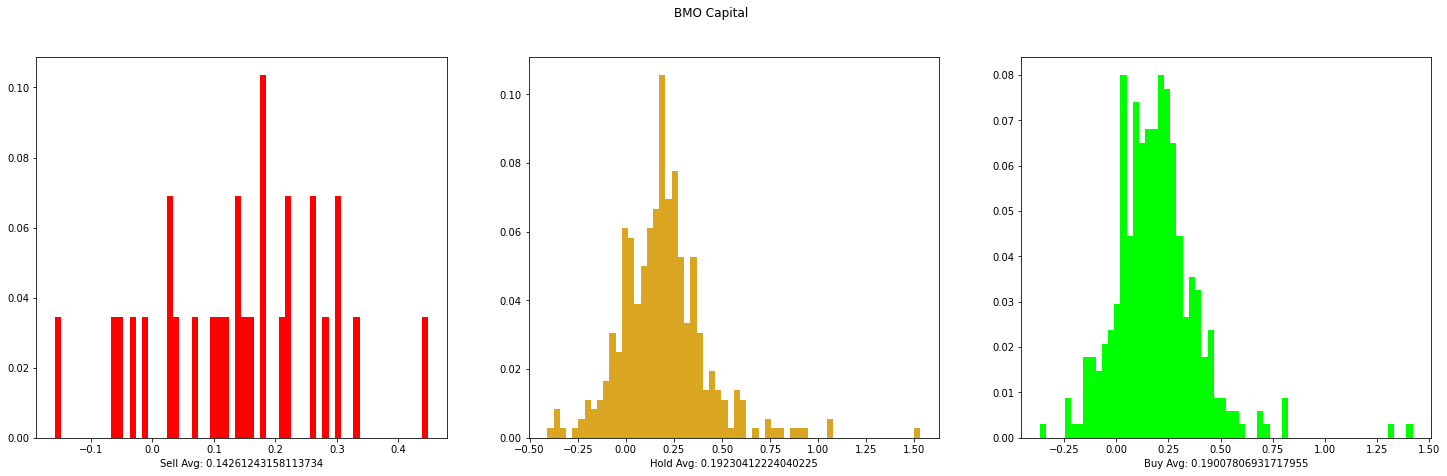

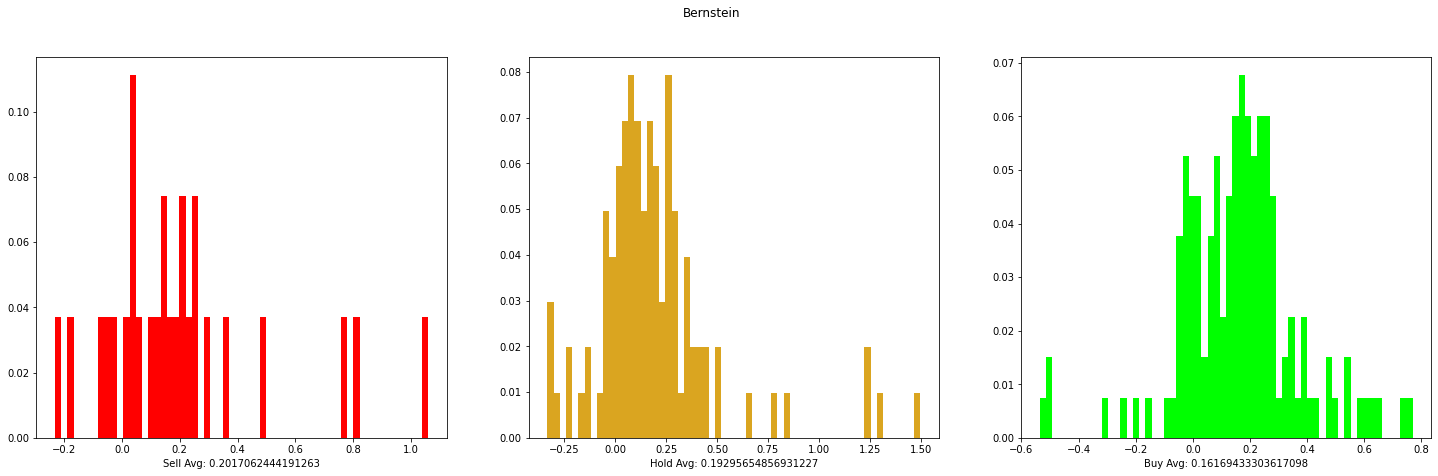

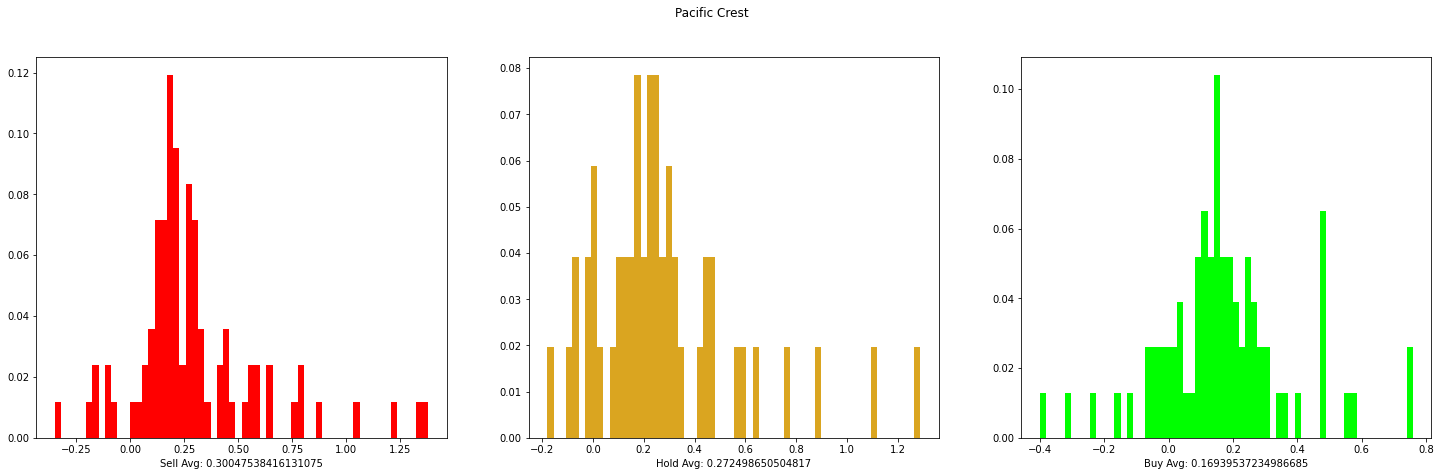

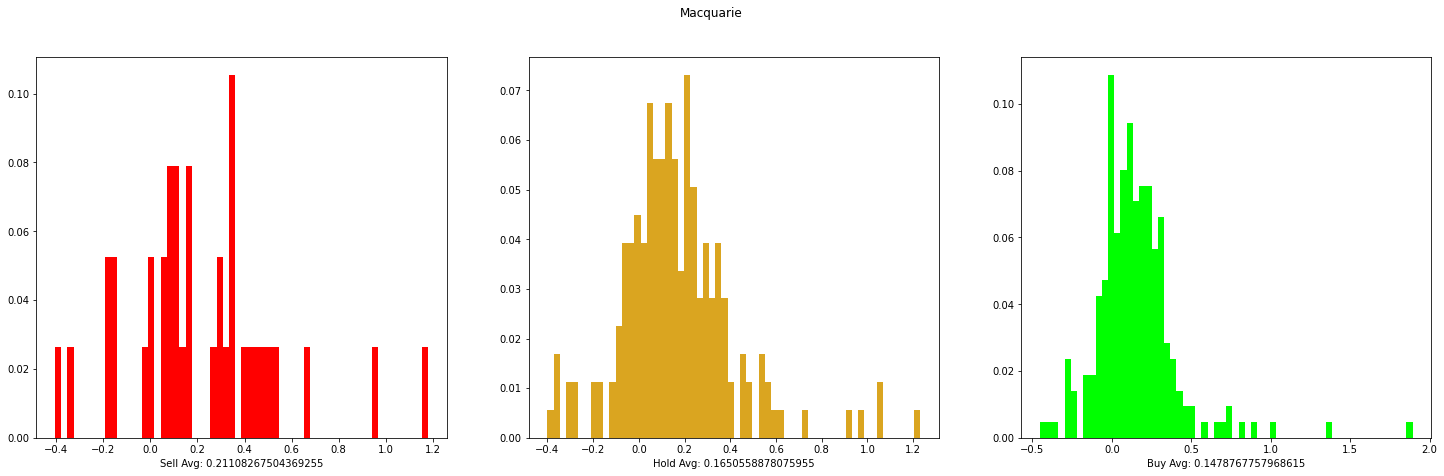

In [3]:
#graph analyst recommendation performance on histogram graph, normalized to 1 year. Early stop is false
graph_performance(graph_type='histogram',tickers=get_tickers_filtered(mktcap_min=30e3),start='2012-01-01',end='2020-01-01',performance_test_period=24,data_type='price',early_stop=False,min_recommendations={'Sell': 25,'Hold': 25,'Buy': 25},convert_type='simple',verbose=False)
